# Self-Driving Car Hacktorial

## Project Goal: Train a Deep Neural Network to drive a simulated car using only images as input.

All the main code here is nicely formatted and runnable in [model.py](/model.py). This notebook is just to visualize the data and walkthrought the entire process. The final model that successfully completes the first track is available as [model.h5](/model.h5).

### Part 1: Imports

In [26]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import scipy.misc
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, ELU, Flatten, MaxPooling2D, Lambda
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import display

tf.python.control_flow_ops = tf

%matplotlib inline

### Part 2: Pre-processing Data

In this section we preprocess all training data before we feed it into the model to train on. The data here is provided by Udacity but you can also create your own using the simulator train option. It is reccomended to try driving in "recovery" paths so the car learns that when you are on the side of the road you should maneuver back to the center.

#### Load data into pandas

In [34]:
# Location of the training data from Udacity.
DATA_FILE = 'driving_log.csv'
IMG_FILES = 'IMG'

# Load the training data into a pandas dataframe.
columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle', 'Break', 'Speed']
data = pd.read_csv(DATA_FILE, names=columns, header=1)

#### What the data looks like

In [4]:
display(data.head())

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
1,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
2,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
3,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
4,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993


#### Statistics about the data.

,Steering Angle,Throttle,Break,Speed
count,8035.000000,8035.000000,8035.000000,8035.000000
mean,0.004070,0.869768,0.001970,28.170589
std,0.128848,0.301188,0.036567,6.149343
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183100
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


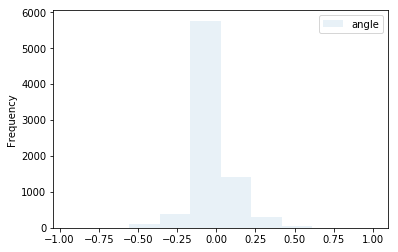

In [28]:
display(data.describe())

df4 = pd.DataFrame({'angle': data['Steering Angle']})
df4.plot.hist(alpha=0.1)

Interesting observations:
1. Steering angle varies between -1.0 and 1.0 but is almost always 0 (driving straight). This is not good as then our model would be biased to driving straight.
2. The car was driven at it's maximum speed most of the time.
3. The throttle was barely adjusted while driving and same with the breaking which was rarely applied.
4. Steering data is biased towards turning left.

#### Sample Images of training data.

These are three samples from the same time momement in the simulation. Notice how the edges and lanes are more visible in the right and left cameras. We will train our model using all three cameras but our final model for prediction will only use our center camera for simplicity. We also need to modify the steering angle by adding and subtracting a small constant for the left and right images to handle the shift.

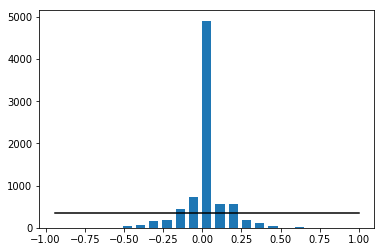

In [37]:
num_bins = 23
avg_samples_per_bin = len(data['Steering Angle'])/num_bins
hist, bins = np.histogram(data['Steering Angle'], num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

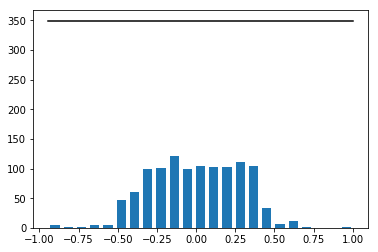

In [38]:
keep_probs = []
target = avg_samples_per_bin * .3
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
        
remove_list = []
for i in range(len(data['Steering Angle'])):
    for j in range(num_bins):
        if data['Steering Angle'][i] > bins[j] and data['Steering Angle'][i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
data.drop(data.index[remove_list], inplace=True)

# print histogram again to show more even distribution of steering angles
hist, bins = np.histogram(data['Steering Angle'], num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(data['Steering Angle']), np.max(data['Steering Angle'])), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

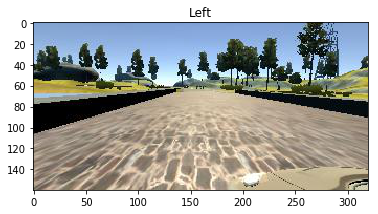

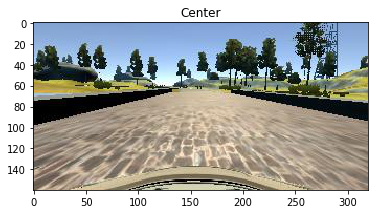

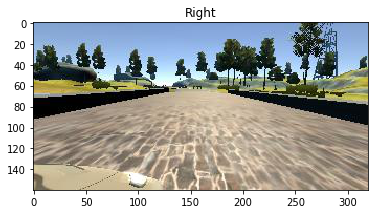

In [6]:
left_image = Image.open('images/left.jpg')
_ = plt.imshow(left_image)
plt.title('Left')
plt.show()

center_image = Image.open('images/center.jpg')
_ = plt.imshow(center_image)
plt.title('Center')
plt.show()

right_image = Image.open('images/right.jpg')
_ = plt.imshow(right_image)
plt.title('Right')
plt.show()

#### Split data into training and testing. Here we use 85% of the data to train and 15% to test our model.

In [7]:
images = data[['Center Image', 'Left Image', 'Right Image']]
angles = data['Steering Angle']

images_train, images_validation, angles_train, angles_validation = train_test_split(
    images, angles, test_size=0.15, random_state=42)

#### Load and preprocess Image

Function which given an image path (what its saved as in the data) gets the image and flips it depending on the parameter passed in. Notice how we keep the color of the image. The function also crops out the sky and car hood to only contain an image of the road. We don't do any other modification here because this method will be used by our validation dataset. We also apply a random tint to darken or brighten the data so it supports different environments or times during the day.

In [8]:
def load_image_and_preprocess(path, flip_image=False, tint_image=False):
    # Open image from disk and flip it if generating data.
    image = Image.open(path.strip())
    
    if flip_image:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
        
    if tint_image:
        image = cv2.imread(path.strip())
        image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        image = np.array(image, dtype = np.float64)
        random_bright = .5+np.random.uniform()
        image[:,:,2] = image[:,:,2]*random_bright
        image[:,:,2][image[:,:,2]>255]  = 255
        image = np.array(image, dtype = np.uint8)
        image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)

    # Convert the image into mulitdimensional matrix of float values (normally int which messes up our division).
    image = np.array(image, np.float32)
    
    # Crop Image
    image = image[35:135, :]
    image = scipy.misc.imresize(image, (66,200))
    
    # Return the modified image.
    return image

#### Add Jitter to image to augment data 

We jitter the image to try to mimic being on a different position on the road.

In [30]:
def jitter_image(path, steering):
    image = cv2.imread(path.strip())
    rows, cols, _ = image.shape
    transRange = 100
    numPixels = 10
    valPixels = 0.4
    transX = transRange * np.random.uniform() - transRange/2
    steering = steering + transX/transRange * 2 * valPixels
    transY = numPixels * np.random.uniform() - numPixels/2
    transMat = np.float32([[1, 0, transX], [0, 1, transY]])
    image = cv2.warpAffine(image, transMat, (cols, rows))
    
    # Convert the image into mulitdimensional matrix of float values (normally int which messes up our division).
    image = np.array(image, np.float32)
    
    # Crop Image
    image = image[35:135, :]
    image = scipy.misc.imresize(image, (66,200))
    
    return image, steering

#### Visualize preprocessing.

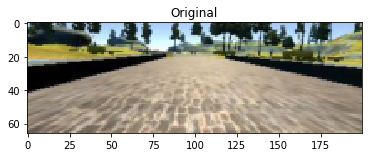

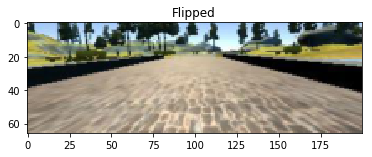

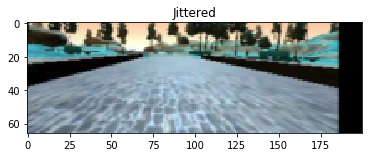

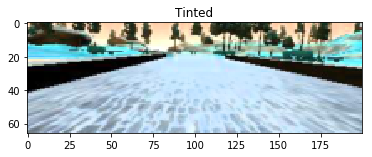

In [39]:
path = 'images/center.jpg'
original_image = load_image_and_preprocess(path, flip_image=False, tint_image=False)
_ = plt.imshow(original_image)
plt.title('Original')
plt.show()

flipped_image = load_image_and_preprocess(path, flip_image=True, tint_image=False)
_ = plt.imshow(flipped_image)
plt.title('Flipped')
plt.show()

jittered_image, steering = jitter_image(path, 0.0)
_ = plt.imshow(jittered_image)
plt.title('Jittered')
plt.show()

tinted_image = load_image_and_preprocess(path, flip_image=False, tint_image=True)
_ = plt.imshow(tinted_image)
plt.title('Tinted')
plt.show()

### Part 3: Generate Batches for training model.

We can create a batch generator which we will take all the data we currently have from the CSV file, augment it and pass it into our model. The goal of the batch generator is to create a data input such that for every image we have the corresponding speed. It also allows us to apply all the preproccessing we did to each image and keep it as our data. 

It would be a good idea here to create more preprocessing methods that do other things such as randomly shear an image, horizontally crop some images to limit data, darken images, etc. to create a better dataset. For the sake of this hacktorial we will limit it to only cropping and flipping.

In [36]:
def batch_generator(images, steering_angles, batch_size=64, augment_data=True):
    # Create an array of sample indices.
    batch_images = []
    batch_steering_angles = []
    sample_count = 0
    SIDE_STEERING_CONSTANT = 0.25
    indices = np.arange(len(images))
    
    while True:
        # Shuffle indices to minimize overfitting. Common procedure.
        np.random.shuffle(indices)
        for i in indices:
            
            # Load the center image and steering angle.
            center_image = load_image_and_preprocess(images.iloc[i]['Center Image'])
            center_angle = float(steering_angles.iloc[i])
            batch_images.append(center_image)
            batch_steering_angles.append(center_angle)
            
            # Add augmentation if needed. We do this because our model only runs on 
            # our center camera feed and we dont want to modify anything other than
            # the cropping and normalizing for our validation dataset since this should
            # work on raw data.
            if augment_data:
                # Flip the image and invert angle respectively.
                flipped_image = load_image_and_preprocess(images.iloc[i]['Center Image'], True, False)
                flipped_angle = -1.0 * center_angle
                batch_images.append(flipped_image)
                batch_steering_angles.append(flipped_angle)
                
                # Tint the center image to random brightness.
                tint_image = load_image_and_preprocess(images.iloc[i]['Center Image'], False, True)
                tint_angle = center_angle
                batch_images.append(tint_image)
                batch_steering_angles.append(tint_angle)
                
                # Jitter the center image to make it seem like different position on road.
                jitter_image, jitter_angle = jitter_image(images.iloc[i]['Center Image'], center_angle)
                batch_images.append(jitter_image)
                batch_steering_angles.append(jitter_angle)

                # Load the left image and add steering constant to compensate for shift.
                left_image = load_image_and_preprocess(images.iloc[i]['Left Image'])
                # Steering angle must stay within the range of -1 and 1
                left_angle = min(1.0, center_angle + SIDE_STEERING_CONSTANT)
                batch_images.append(left_image)
                batch_steering_angles.append(left_angle)

                # Load the left image and subtract steering constant to compensate for shift.
                right_image = load_image_and_preprocess(images.iloc[i]['Right Image'])
                # Steering angle must stay within the range of -1 and 1
                right_angle = max(-1.0, center_angle - SIDE_STEERING_CONSTANT)
                batch_images.append(right_image)
                batch_steering_angles.append(right_angle)
                
            # Increment the number of samples. 
            sample_count += 1
            
            # If we have processed batch_size number samples or this is the last batch
            # of the epoch, then we submit the batch. Since we augment the data there is a chance
            # we have more than the number of batch_size elements in each batch.
            if (sample_count % batch_size) == 0 or (sample_count % len(images)) == 0:
                yield np.array(batch_images), np.array(batch_steering_angles)
                # Reset
                batch_images = []
                batch_steering_angles = []

### Part 4: Create the model.

Model is based on NVIDIA's "End to End Learning for Self-Driving Cars" paper https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf.

Difference between this model and NVIDIA's is an additional maxpooling layer after every convolutional layer to speed up computation.

In [ ]:
activation_relu = 'relu'
learning_rate = 1e-4

model = Sequential()

model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(66, 200, 3)))

# starts with five convolutional and maxpooling layers
model.add(Convolution2D(24, (5, 5), border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))p0o9.l=

model.add(Convolution2D(36, (5, 5), border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(48, (5, 5), border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, (3, 3), border_mode='same', subsample=(1, 1)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, (3, 3), border_mode='same', subsample=(1, 1)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Flatten())

# Next, five fully connected layers
model.add(Dense(1164))
model.add(Activation(activation_relu))
model.add(Dense(100))
model.add(Activation(activation_relu))
model.add(Dense(50))
model.add(Activation(activation_relu))
model.add(Dense(10))
model.add(Activation(activation_relu))

model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate), loss="mse", )

#### Model Summary

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 33, 100, 24)       1824      
_________________________________________________________________
activation_19 (Activation)   (None, 33, 100, 24)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 99, 24)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 50, 36)        21636     
_________________________________________________________________
activation_20 (Activation)   (None, 16, 50, 36)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 49, 36)        0         
__________

### Part 5: Train Model

Generate data with augmentation and validation and then fit it to the model.

In [40]:
nb_epoch = 15

samples_per_epoch = 6 * len(images_train)
generator_train = batch_generator(images_train, angles_train)

nb_val_samples = len(images_validation)
generator_validation = batch_generator(images_validation, angles_validation, augment_data=False)

Fit data to model.

In [ ]:
history = model.fit_generator(generator_train, 
                              samples_per_epoch=samples_per_epoch, 
                              nb_epoch=nb_epoch,
                              validation_data=generator_validation, 
                              nb_val_samples=nb_val_samples)

Save model for later use.

In [ ]:
model.save_weights('model.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

Visualize training loss on training and validation.

In [ ]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Part 6: Running the simulation

python drive.py model.json